In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.style.use('ggplot')

# Dataset overview

In [4]:
df = pd.read_pickle("data/preprocessed/collaborative_df.pkl")
df.sample(10)

,user_id,recipe_name,rating
425574,33986,860,6
557003,44477,619,5
2242551,175129,1315,5
1924005,151078,422,5
89253,7235,18,5
1316865,102516,17,5
2500599,197396,1739,5
1642023,127147,1665,5
1195273,92602,855,5
2492819,196728,1386,5


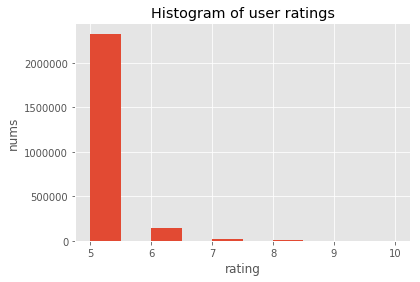

In [5]:
df.rating.hist()
plt.xlabel("rating")
plt.ylabel("nums")
plt.title("Histogram of user ratings");

In [6]:
print(f"Our dataset have {df.user_id.max()} unique users' favorite {len(df)} recipes in total.")
print(f"Recipes are mapped within {len(df.recipe_name.unique())} categories.")
print(f"User ratings are shown above, mean value is {df.rating.mean()}, maximum is {df.rating.max()}.")

Our dataset have 198816 unique users' favorite 2511218 recipes in total.
Recipes are mapped within 1628 categories.
User ratings are shown above, mean value is 5.091716051732665, maximum is 10.


In [7]:
from surprise import dump
from surprise.accuracy import rmse
from collab_filter import load_trained_pred_algo

# NMF algorithm 

*\*baseline*

In [8]:
df_nmf, predictions_nmf, algo_nmf = load_trained_pred_algo('models/dump_NMF')

# SVD algorithm

In [9]:
df_svd, predictions_svd, algo_svd = load_trained_pred_algo('models/dump_SVD')

## Compare with NMF

### RMSE

In [10]:
print("[SVD]", end=" "); rmse(predictions_svd);
print("[NMF]", end=" "); rmse(predictions_nmf);

[SVD] RMSE: 0.3653
[NMF] RMSE: 0.5845


### Recall

We define the **miss** as if the recipe error of $(true - estimation) > 0.05$.<br>
Since the rating feature actually represents the binary favor (like or not like), rather than measurement of some recipes.<br>
So the estimation is quite close, as you can see in the above figure, errors are mainly distributed in range $[0,\ 1]$.<br>
Therefore, we have to choose relatively small error to calculate **recall**, which means the number of the predicted most-like recipes over the number of true right recipes, i.e., $$\frac{TP}{TP + FN}$$ where $TP=true\ positive$ and $FN=false\ negative$

In [17]:
from collab_filter import cal_recall
ERROR_THRESHOLD = 0.05

In [18]:
recall_svd = cal_recall(predictions_svd, ERROR_THRESHOLD)
print(f"[SVD] Recalls: {np.array(list(recall_svd.values())).mean():.4f}")

[SVD] Recalls: 0.9234


In [19]:
recall_nmf = cal_recall(predictions_nmf, ERROR_THRESHOLD)
print(f"[NMF] Recalls: {np.array(list(recall_nmf.values())).mean():.4f}")

[NMF] Recalls: 0.5406


### Prediction

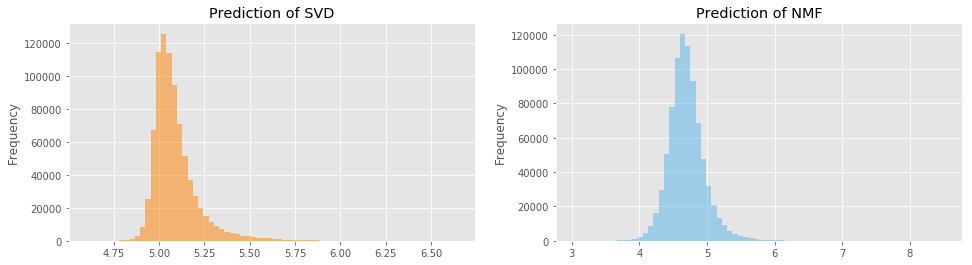

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_svd.estimation.plot(ax=ax1, kind='hist', bins=70, title='Prediction of SVD', color="#FF8000", alpha=0.5);
df_nmf.estimation.plot(ax=ax2, kind='hist', bins=70, title='Prediction of NMF', color="#56B4E9", alpha=0.5);

## Error analysis of SVD

In [12]:
df_svd['err'] = abs(df_svd.estimation - df_svd.rating)
df_svd.sample(10)

,user_id,item_id,rating,estimation,err
685928,147617,42,5.0,5.063411,0.063411
117609,152198,327,5.0,5.086939,0.086939
384821,25929,1793,5.0,5.348602,0.348602
772942,149153,337,5.0,5.397983,0.397983
646286,5305,176,5.0,5.002520,0.002520
503089,99054,1714,5.0,5.151476,0.151476
580886,125842,348,5.0,5.019453,0.019453
25991,179450,1350,5.0,4.991168,0.008832
158472,185827,903,5.0,5.070087,0.070087
513333,120282,180,5.0,5.148126,0.148126


In [13]:
best_predictions = df_svd.sort_values(by='err')[:10]
worst_predictions = df_svd.sort_values(by='err')[-10:]

Prediction with the smallest error

In [14]:
best_predictions

,user_id,item_id,rating,estimation,err
381030,103789,1752,5.0,5.000000,1.123499e-07
270930,21172,472,5.0,5.000000,1.219079e-07
270879,96108,160,5.0,5.000000,2.796971e-07
182842,63732,1527,5.0,5.000000,3.924164e-07
376789,47681,622,5.0,5.000000,4.454907e-07
285241,17556,333,5.0,5.000001,5.337511e-07
42650,35721,51,5.0,4.999999,6.629452e-07
488167,191697,584,5.0,5.000001,6.725527e-07
653525,180711,1724,5.0,4.999999,6.841365e-07
403244,10927,1736,5.0,5.000001,1.021761e-06


Prediction with the biggest error

In [15]:
worst_predictions

,user_id,item_id,rating,estimation,err
435447,188183,440,10.0,5.009860,4.990140
715657,55594,502,10.0,5.005795,4.994205
744533,66025,136,10.0,5.005194,4.994806
608121,164151,502,10.0,5.002467,4.997533
325207,114305,502,10.0,5.001044,4.998956
343551,73164,2006,10.0,4.996667,5.003333
484218,111104,1587,10.0,4.996573,5.003427
14646,57484,2030,10.0,4.970776,5.029224
319127,195629,1775,10.0,4.962710,5.037290
807703,66215,1984,10.0,4.835887,5.164113


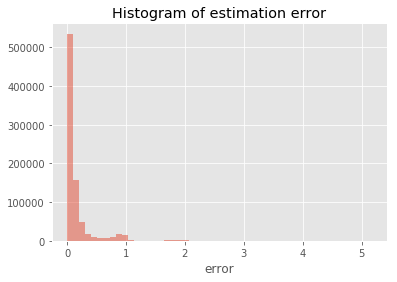

In [16]:
df_svd['err'].hist(bins=50, alpha=0.5)
plt.xlabel("error")
plt.title("Histogram of estimation error");

## Recommendations

In [20]:
import json
from collab_filter import top_k
from pathlib import Path

In [21]:
top_5 = top_k(predictions_svd, 5)
dictionary = json.load(Path("data/preprocessed/dictionary.json").open(encoding="utf-8"))

In [22]:
recipe_id_to_english = {ind: v for ind, (k, v) in enumerate(dictionary.items())}

In [23]:
def display_recommend(data, dictionary, ind=None):
    if ind is None:
        ind = np.random.randint(0, high=len(data))
    try:
        print(f"Recommendation for user [{ind}]")
        for recipe_id, rates in data[ind]:
            print(f"·{dictionary[recipe_id]}: {rates:.3f}")
    except KeyError:
        print(f"User {ind} doesn't exist.")

In [24]:
display_recommend(top_5, recipe_id_to_english)

Recommendation for user [91346]
·Boiled Fish with Pickled Cabbage and Chili: 5.075
·Sautéed Bitter Melon Peel in Black Bean Sauce: 5.066
·Sautéed Hardshell Crab with Salted Egg Yolk: 5.044
·Seafood Bowl with Assorted Ingredients: 5.038
·Spaghetti Bolognaise: 5.023


## *Appendix: Grid search*

In [25]:
from collab_filter import load_dataset
from surprise import SVD
from surprise.model_selection import GridSearchCV, KFold

In [26]:
def train_grid_search():
    data = load_dataset()
    param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all' : [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    table = [[] for _ in range(len(gs.cv_results['params']))]
    for i in range(len(gs.cv_results['params'])):
        for key in gs.cv_results.keys():
            table[i].append(gs.cv_results[key][i])
    headers = gs.cv_results.keys()
    return pd.DataFrame(table, columns=headers, index=gs.cv_results["params"])

In [27]:
csv_path = Path("res/svd_grid_serach.csv")
if csv_path.exists():
    df = pd.read_csv(str(csv_path), index_col=0)
else:
    df = train_grid_search()
    df.to_csv(str(csv_path))

In [28]:
# Remove repeated columns for better 
pd.options.display.float_format = '{:.4f}'.format
df.index.rename('params', inplace=True)
df.drop([h for h in df.head() if h .startswith("param")], axis=1)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time
params,,,,,,,,,,,,,,,,
"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",0.3644,0.3609,0.3628,0.3627,0.0014,6,0.1582,0.1577,0.1582,0.1580,0.0002,4,29.4713,0.0564,8.9317,0.0898
"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",0.3650,0.3614,0.3634,0.3633,0.0014,8,0.1593,0.1588,0.1594,0.1592,0.0003,7,28.8231,0.1532,8.8813,0.0402
"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",0.3638,0.3603,0.3620,0.3620,0.0014,2,0.1573,0.1568,0.1581,0.1574,0.0005,1,29.3047,0.7659,9.3364,0.7014
"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",0.3645,0.3609,0.3626,0.3627,0.0015,5,0.1587,0.1582,0.1595,0.1588,0.0005,6,29.8173,0.9193,9.6570,1.1730
"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",0.3637,0.3601,0.3621,0.3620,0.0014,1,0.1581,0.1575,0.1580,0.1579,0.0002,3,56.7222,0.0553,9.3279,0.6558
"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.6}",0.3644,0.3608,0.3628,0.3626,0.0014,4,0.1594,0.1588,0.1594,0.1592,0.0003,8,56.8888,0.2027,8.9146,0.0008
"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",0.3641,0.3605,0.3623,0.3623,0.0015,3,0.1574,0.1570,0.1582,0.1575,0.0005,2,56.7971,0.1359,8.8146,0.0142
"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}",0.3647,0.3611,0.3629,0.3629,0.0015,7,0.1585,0.1581,0.1593,0.1586,0.0005,5,56.8352,0.1780,9.3248,0.6603
